In [264]:
import networkx as nx
import numpy as np
import numpy.typing as npt
from scipy.sparse._csr import csr_array
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import matplotlib.animation as ani

# Network setup

## Sythetic
Barabasi-Albert model

### Structure

In [46]:
num_nodes = 10
min_edges = 2

graph = nx.barabasi_albert_graph(n=num_nodes, m=min_edges, seed=0).to_directed()

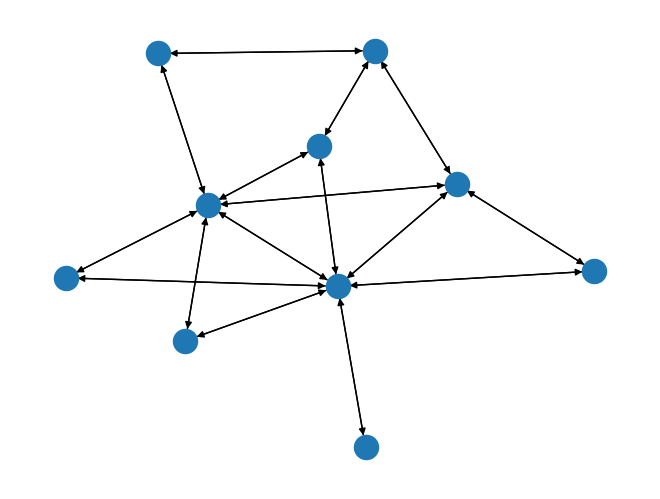

In [47]:
pos = nx.spring_layout(graph, seed=1)
nx.draw(graph, pos=pos)

### Parameters

In [184]:
for node in graph.nodes:
    graph.nodes[node]["total_pop"] = float(graph.out_degree[node]) # Subpopulation size N_n : Node attribute "total_pop" 

for edge in graph.edges:
    graph[edge[0]][edge[1]]["weight"] = 0.0001 * graph.nodes[edge[0]]["total_pop"] * graph.nodes[edge[1]]["total_pop"] # Traffic flux F_nm : Edge attribute "weight"

### Draw

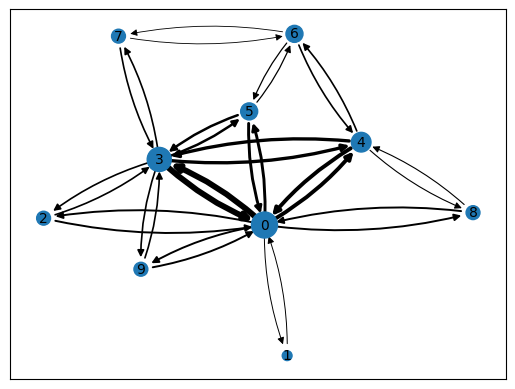

In [185]:
nx.draw_networkx(
    graph, 
    pos = pos,
    node_size = [graph.nodes[node]["total_pop"] * 50 for node in graph.nodes],
    font_size = 10,
    edgelist=[],
)

for edge in graph.edges(data='weight'):
    nx.draw_networkx_edges(
        graph, 
        pos, 
        edgelist=[edge], 
        width=graph[edge[0]][edge[1]]["weight"] * 1000,
        connectionstyle="arc3,rad=0.1",
    )

## Network parameters

In [202]:
total_pops = np.array([graph.nodes[node]["total_pop"] for node in graph.nodes])
adj_mat = nx.adjacency_matrix(graph, weight="weight", dtype=np.float64)

# Model definition
Metapopulation SIR model

In [187]:
arr64 = npt.NDArray[np.float64]

In [ ]:
def get_velocity(
    time: float, 
    pop_fracs: arr64, # Population fractions array
    i_rate: np.float64, # alpha
    r_rate: np.float64, # beta
    total_pops: arr64, # N_n array
    adj_mat: csr_array, # F_nm adjacency matrix
    num_nodes: int,
) -> arr64:
    """
    Metapopulation SIR model equations
    """

    i_fracs = pop_fracs[:num_nodes] # Infected population fraction
    s_fracs = pop_fracs[num_nodes:] # Susceptible population fraction

    d_i_fracs = i_rate * s_fracs * i_fracs - r_rate * i_fracs + (adj_mat.dot(i_fracs) - adj_mat.sum(axis=0) * i_fracs) / total_pops
    d_s_fracs = -i_rate * s_fracs * i_fracs + (adj_mat.dot(s_fracs) - adj_mat.sum(axis=0) * s_fracs) / total_pops

    return np.concatenate((d_i_fracs, d_s_fracs), axis=0)

## Test

In [ ]:
i_fracs = np.array([0.01] + [0.0 for _ in range(9)], dtype=np.float64)
s_fracs = np.array([0.99] + [1.0 for _ in range(9)], dtype=np.float64)
pop = np.concatenate((i_fracs, s_fracs), axis=0)

In [216]:
get_velocity(0, pop, 0.2, 0.04, total_pops, adj_mat, num_nodes)

array([ 1.56e-03,  7.00e-06,  7.00e-06,  7.00e-06,  7.00e-06,  7.00e-06,
        0.00e+00,  0.00e+00,  7.00e-06,  7.00e-06, -1.96e-03, -7.00e-06,
       -7.00e-06, -7.00e-06, -7.00e-06, -7.00e-06,  0.00e+00,  0.00e+00,
       -7.00e-06, -7.00e-06])

# Solve

## Parameters

In [ ]:
# Model parameters

i_rate = 0.2 # alpha
r_rate = 0.04 # beta

In [289]:
# Initial points

origin = 7 # Node where infection starts
orig_i_pop = 0.001 # Initial infected fraction

init_i_pop = np.zeros(num_nodes, dtype=np.float64)
init_i_pop[origin] = orig_i_pop
init_s_pop = np.ones(num_nodes, dtype = np.float64) - init_i_pop

In [ ]:
# Results formatting

max_time = 500
eval_rate = 50
eval_time = np.arange(1, eval_rate * max_time) / eval_rate

## Actual solve

In [301]:
result = solve_ivp(
    get_velocity,
    t_span=(0, max_time),
    y0=np.concatenate((init_i_pop, init_s_pop), axis=0),
    method="DOP853",
    t_eval=eval_time,
    args=(i_rate, r_rate, total_pops, adj_mat, num_nodes),
    atol=1e-11,
    rtol=1e-11,
)

In [291]:
result["message"]

'The solver successfully reached the end of the integration interval.'

# Visualization

## Plots

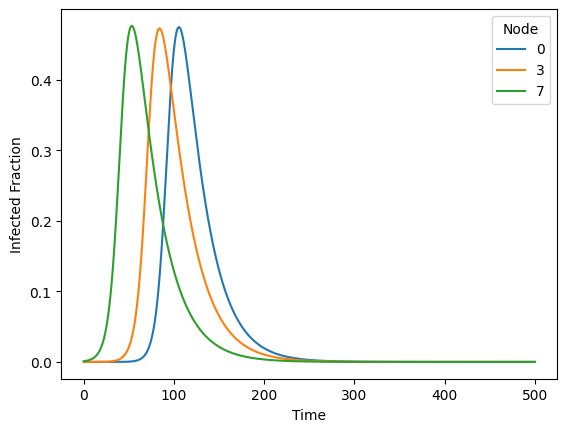

In [292]:
nodes = [0, 3, 7]

for node in nodes:
    plt.plot(result["t"], result["y"][node], label=node)

plt.xlabel("Time")
plt.ylabel("Infected Fraction")
plt.legend(title="Node")

## Peaks

In [293]:
peak_times = np.zeros(num_nodes)
peak_i_fracs = np.zeros(num_nodes)

for node in range(num_nodes):
    peak_i_fracs[node] = result["y"][node].max()
    peak_times[node] = result["t"][result["y"][node].argmax()]

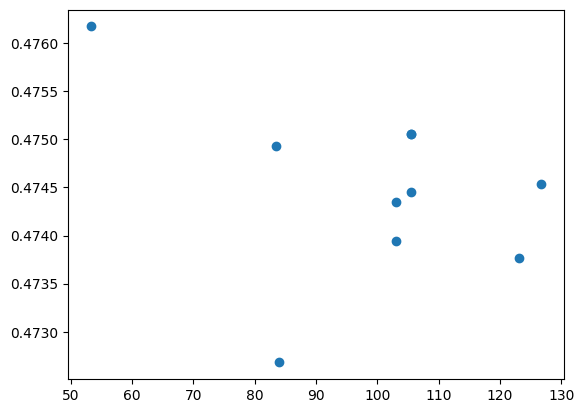

In [294]:
plt.scatter(peak_times, peak_i_fracs)

## Animation

In [302]:
# Color normalization

i_frac_max = result["y"][:num_nodes, :].max()

r_fracs = 1.0 - result["y"][num_nodes:, :] - result["y"][:num_nodes, :]
r_frac_max = r_fracs.max()

In [297]:
# Time formatting

total_len = result["t"].shape[0] // 2
ani_len = 10 # seconds
fps = 20 

stride = (total_len+1) // (ani_len*fps)

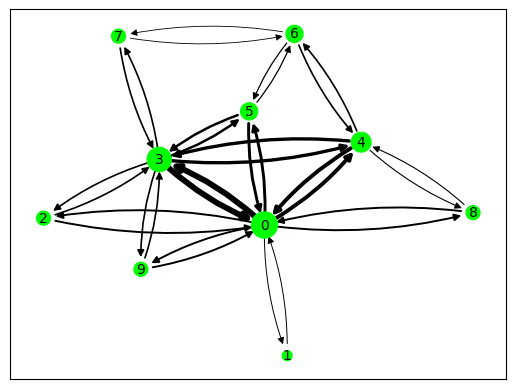

In [305]:
fig, ax = plt.subplots()

def update(frame):
    time = stride * frame

    plt.cla()

    artists = []

    node_markers = nx.draw_networkx(
        graph, 
        ax = ax,
        pos = pos,
        node_size = [graph.nodes[node]["total_pop"] * 50 for node in graph.nodes],
        node_color = [
            (
                result["y"][node, time] / i_frac_max, # Infected => Red
                result["y"][node+num_nodes, time], # Susceptible => Green
                max((1.0 - result["y"][node+num_nodes, time] - result["y"][node, time]) / r_frac_max, 0) # Recovered => Blue
            )
            for node in range(num_nodes)
        ],
        font_size = 10,
        edgelist=[],
    )
    artists.append(node_markers)

    for edge in graph.edges(data='weight'):
        edge_line = nx.draw_networkx_edges(
            graph, 
            pos, 
            ax = ax,
            edgelist=[edge], 
            width=graph[edge[0]][edge[1]]["weight"] * 1000,
            connectionstyle="arc3,rad=0.1",
        )
        artists.append(edge_line)
    
    return artists

animation = ani.FuncAnimation(fig=fig, func=update, frames=fps * ani_len, interval = 1000 / fps)
animation.save(f"test_origin-{origin}.gif", writer=ani.PillowWriter(fps=fps))